# AIM0403D2203 Text Classification (Machine Learning)
---
Hari ini, kita akan menyelesaikan kasus klasifikasi SMS spam menggunakan skema seperti gambar di bawah ini.

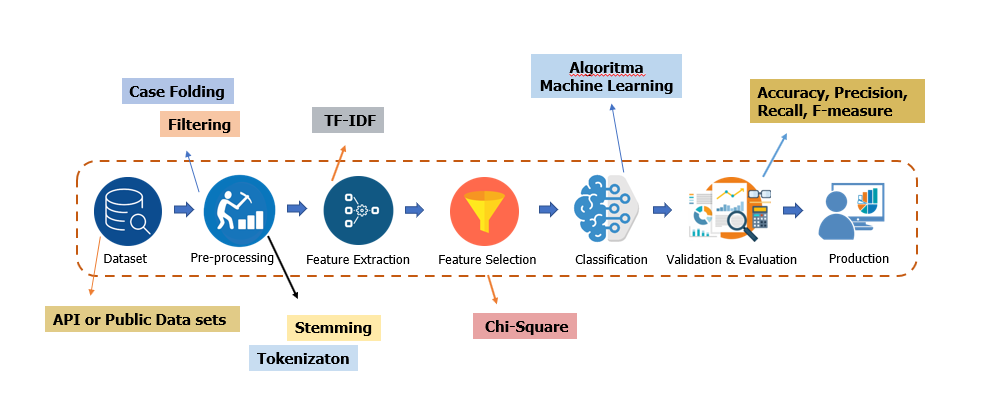

Langkah-langkah penyelesaian meliputi:
1. Data Acquisition
2. Text Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
3. Feature Engineering
   1. Feature Extraction - BoW & TF IDF
   2. Feature Selection - Chi-Square
4. Modelling (Machine Learning)
5. Model Evaluation
6. Deployment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [2]:
# Install library Sastrawi
!pip -q install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.2 MB/s eta 0:00:00


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 01 Data Acquisition

Penjelasan Label 
* 0: Kalimat normal 
* 1: Kalimat Cyberbullying

In [4]:
# Download dataset
!wget https://raw.githubusercontent.com/RomySyaputra/dataset_cyberbullying/main/Dataset_Cyberbullying.csv

--2023-06-06 09:19:39--  https://raw.githubusercontent.com/RomySyaputra/dataset_cyberbullying/main/Dataset_Cyberbullying.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1209195 (1.2M) [text/plain]
Saving to: ‘Dataset_Cyberbullying.csv’

Dataset_Cyberbullyi 100%[===================>]   1.15M  --.-KB/s    in 0.02s   

2023-06-06 09:19:39 (47.1 MB/s) - ‘Dataset_Cyberbullying.csv’ saved [1209195/1209195]



In [5]:
data = pd.read_csv('Dataset_Cyberbullying.csv')
data.head()

,teks,label
0,Capres Alternatif 2019 Fahri Hamzah - Fadli Zo...,yes
1,"Hari ini cuaca sangat cerah, semoga kamu memil...",no
2,Makasih ya udah selalu ada buat aku. Kamu tema...,no
3,TOLOL!! Gak ada hubungan nya keguguran dgn pak...,yes
4,eh... Situ siapa??? Kids jaman now ya kebanyak...,yes


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10300 entries, 0 to 10299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    10300 non-null  object
 1   label   10300 non-null  object
dtypes: object(2)
memory usage: 161.1+ KB


In [11]:
print('Total Jumlah Teks:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] Teks Normal\t:', data[data.label == "no"].shape[0], 'data')
print('-- [1] Teks Cyberbullying\t:', data[data.label == "yes"].shape[0], 'data')

Total Jumlah Teks: 10300 data

terdiri dari (label):
-- [0] Teks Normal	: 5150 data
-- [1] Teks Cyberbullying	: 5150 data


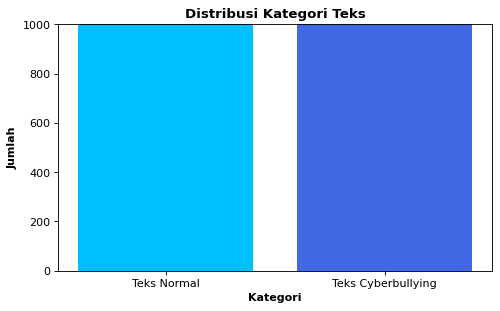

In [12]:
height = data['label'].value_counts()
labels = ('Teks Normal', 'Teks Cyberbullying')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,1000)
plt.title('Distribusi Kategori Teks', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue'])
plt.xticks(y_pos, labels)
plt.show()

# 02 Text Preprocessing

## Case Folding

In [13]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [14]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  ahhh katanya jaga ucapan, lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga Tuhan ampunin kemunafikan loe cun
Case folding	:  ahhh katanya jaga ucapan lahh ucapan dia ngk dijaga sendiri dasar munafik dasar betina zaman now ellu kali yangg kelebihan micin loe sendiri otak loe kan di selangkangan mana paham semoga tuhan ampunin kemunafikan loe cun


## Word Normalization

In [15]:
# Download corpus kumpulan slangwords
!wget https://raw.githubusercontent.com/RomySyaputra/dataset_cyberbullying/main/kamus.csv

--2023-06-06 09:20:39--  https://raw.githubusercontent.com/RomySyaputra/dataset_cyberbullying/main/kamus.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136842 (134K) [text/plain]
Saving to: ‘kamus.csv’

kamus.csv           100%[===================>] 133.63K  --.-KB/s    in 0.007s  

2023-06-06 09:20:39 (17.6 MB/s) - ‘kamus.csv’ saved [136842/136842]



In [16]:
key_norm = pd.read_csv('kamus.csv')
print(key_norm.head())

key_norm.shape

   _id singkat       hasil
0    1    abis       habis
1   14      ad         ada
2   23  agency  perwakilan
3   30      aj        saja
4   31     aja        saja


(5222, 3)

In [17]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [18]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [19]:
len(stopwords_ind)

758

In [20]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [21]:
# Buat fungsi untuk langkah stopword removal

stopwords_ind = stopwords_ind 

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [22]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  ahhh katanya jaga ucapan, lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga Tuhan ampunin kemunafikan loe cun
Case folding		:  ahhh katanya jaga ucapan lahh ucapan dia ngk dijaga sendiri dasar munafik dasar betina zaman now ellu kali yangg kelebihan micin loe sendiri otak loe kan di selangkangan mana paham semoga tuhan ampunin kemunafikan loe cun
Stopword removal	:  ahhh jaga ucapan lahh ucapan ngk dijaga dasar munafik dasar betina zaman now ellu kali yangg kelebihan micin loe otak loe selangkangan paham semoga tuhan ampunin kemunafikan loe cun


## Stemming

In [23]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [24]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  ahhh katanya jaga ucapan, lahh ucapan dia ngk dijaga sendiri.. dasar munafik.. dasar betina zaman now ellu kali yangg kelebihan micin.. loe sendiri otak loe kan di selangkangan mana paham.. semoga Tuhan ampunin kemunafikan loe cun
Case folding		:  ahhh katanya jaga ucapan lahh ucapan dia ngk dijaga sendiri dasar munafik dasar betina zaman now ellu kali yangg kelebihan micin loe sendiri otak loe kan di selangkangan mana paham semoga tuhan ampunin kemunafikan loe cun
Stopword removal	:  ahhh jaga ucapan lahh ucapan ngk dijaga dasar munafik dasar betina zaman now ellu kali yangg kelebihan micin loe otak loe selangkangan paham semoga tuhan ampunin kemunafikan loe cun
Stemming		:  ahhh jaga ucap lahh ucap ngk jaga dasar munafik dasar betina zaman now ellu kali yangg lebih micin loe otak loe selangkang paham moga tuhan ampunin munafik loe cun


## Text Preprocessing Pipeline

In [25]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [26]:
%%time
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)



CPU times: user 28min 50s, sys: 5.78 s, total: 28min 56s
Wall time: 29min 16s


In [27]:
data

,teks,label,clean_teks
0,Capres Alternatif 2019 Fahri Hamzah - Fadli Zo...,yes,capres alternatif fahri hamzah fadli zon bawa ...
1,"Hari ini cuaca sangat cerah, semoga kamu memil...",no,cuaca cerah moga milik senang
2,Makasih ya udah selalu ada buat aku. Kamu tema...,no,terimakasih ya teman baik
3,TOLOL!! Gak ada hubungan nya keguguran dgn pak...,yes,tolol hubung nya gugur pakai hijab syar bilang...
4,eh... Situ siapa??? Kids jaman now ya kebanyak...,yes,eh situ kids jaman ya banyak micin ngina bodoh...
...,...,...,...
10295,Lo tuh cuman bisa bikin orang jijik.,yes,tuh bikin orang jijik
10296,Kamu tuh sebenernya nggak ada manfaatnya,yes,tuh manfaat
10297,"Kalo cuma bisa nyinyir, lebih baik diam aja!",yes,nyinyir diam
10298,Lo bener-bener bikin muak.,yes,benerbener bikin muak


In [28]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# 03 Feature Engineering

In [29]:
# Pisahkan kolom fitur dan target
X = data['clean_teks']
y = data['label']

In [30]:
X

0        capres alternatif fahri hamzah fadli zon bawa ...
1                            cuaca cerah moga milik senang
2                                terimakasih ya teman baik
3        tolol hubung nya gugur pakai hijab syar bilang...
4        eh situ kids jaman ya banyak micin ngina bodoh...
                               ...                        
10295                                tuh bikin orang jijik
10296                                          tuh manfaat
10297                                         nyinyir diam
10298                                benerbener bikin muak
10299                                     orang guna dunia
Name: clean_teks, Length: 10300, dtype: object

In [31]:
y

0        yes
1         no
2         no
3        yes
4        yes
        ... 
10295    yes
10296    yes
10297    yes
10298    yes
10299    yes
Name: label, Length: 10300, dtype: object

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [32]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X) #yang di ekstraksi adalah X (fiturnya)

TfidfVectorizer()

In [33]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

18066


In [34]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aaa' 'aaaa' ... 'zzzzz' 'zzzzzz' 'zzzzzzzz']


In [35]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

tf_idf_feature = {}

for v, index in tf_idf.vocabulary_.items():
    tf_idf_feature[v] = index

In [37]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aaa,aaaa,aaaaa,aaaaaaa,aaaaaaaaa,aaaaaaaaaaa,aaaaaaaaaaaaaaa,aaaaaaaaaah,aaaaaaah,...,zu,zuhair,zul,zulkarnain,zulkifli,zumi,zuyle,zzzzz,zzzzzz,zzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(tf_idf_feature, output)

# 04 Modelling (Machine Learning)

In [39]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [40]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, test_size=0.2, random_state=40)

In [53]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_nb.joblib')

['model_nb.joblib']

In [42]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array(['yes', 'no', 'no', ..., 'yes', 'yes', 'no'], dtype='<U3')

In [43]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

3227    yes
8162     no
6652     no
9112     no
220     yes
       ... 
8706     no
1282     no
4294    yes
348     yes
9050     no
Name: label, Length: 2060, dtype: object

# 05 Model Evaluation

In [44]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 1656
Jumlah prediksi salah	: 404
Akurasi pengujian	: 80.3883495145631 %


In [45]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[728 290]
 [114 928]]


In [46]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

          no       0.86      0.72      0.78      1018
         yes       0.76      0.89      0.82      1042

    accuracy                           0.80      2060
   macro avg       0.81      0.80      0.80      2060
weighted avg       0.81      0.80      0.80      2060



In [47]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_tf_idf, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.8092233  0.80825243 0.78932039 0.80242718 0.80485437 0.8038835
 0.79223301 0.83009709 0.80873786 0.80679612] 

Rata-rata akurasi pada cross validation: 0.8055825242718446


# 06 Simple Deployment


In [48]:
from joblib import load

# load model
model = load('model_nb.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('tf_idf_feature.pickle', 'rb'))

In [57]:
#@title Masukkan Teks Anda:
input_text = " ANJING gue jg ogah liat muke lu" #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result=='no'):
  teks = 'teks normal'
else:
  teks = 'teks cyberbullying'

print('Hasil prediksi', input_text, ' adalah\n', teks)

Hasil Text Preprocessing : anjing ogah lihat muka
Hasil prediksi  ANJING gue jg ogah liat muke lu  adalah
 teks cyberbullying


In [58]:
#@title Masukkan Teks Anda:
input_text2 = "anjing itu berwarna hitam" #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text2)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result=='no'):
  teks = 'teks normal'
else:
  teks = 'teks cyberbullying'

print('Hasil prediksi', input_text2, ' adalah\n', teks)

Hasil Text Preprocessing : anjing warna hitam
Hasil prediksi anjing itu berwarna hitam  adalah
 teks normal
